# Processing of Tabula Sapiens Atlas Dataset

# 1. Pre-requisites
## 1.1 Import packages

In [1]:
import scanpy as sc
import pandas as pd
import cellxgene_census
import anndata as ad
import tiledbsoma as soma
from tiledbsoma.experiment_query import X_as_series
import numpy as np

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## 1.2 Read in data from the CELLxGENE census

I want to search for and download the Tabula Sapiens Atlas from the Census API.

In [35]:
#open the census database
census = cellxgene_census.open_soma()

The "stable" release is currently 2023-07-25. Specify 'census_version="2023-07-25"' in future calls to open_soma() to ensure data consistency.


In [37]:
#fetch datasets in census and output to a dataframe
datasets_df = census["census_info"]["datasets"].read().concat().to_pandas()

datasets_df

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
0,0,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,f171db61-e57e-4535-a06a-35d8b6ef8f2b,donor_p13_trophoblasts,f171db61-e57e-4535-a06a-35d8b6ef8f2b.h5ad,31497
1,1,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,ecf2e08e-2032-4a9e-b466-b65b395f4a02,All donors trophoblasts,ecf2e08e-2032-4a9e-b466-b65b395f4a02.h5ad,67070
2,2,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,74cff64f-9da9-4b2a-9b3b-8a04a1598040,All donors all cell states (in vivo),74cff64f-9da9-4b2a-9b3b-8a04a1598040.h5ad,286326
3,3,f7cecffa-00b4-4560-a29a-8ad626b8ee08,Mapping single-cell transcriptomes in the intr...,10.1016/j.ccell.2022.11.001,5af90777-6760-4003-9dba-8f945fec6fdf,Single-cell transcriptomic datasets of Renal c...,5af90777-6760-4003-9dba-8f945fec6fdf.h5ad,270855
4,4,3f50314f-bdc9-40c6-8e4a-b0901ebfbe4c,Single-cell sequencing links multiregional imm...,10.1016/j.ccell.2021.03.007,bd65a70f-b274-4133-b9dd-0d1431b6af34,Single-cell sequencing links multiregional imm...,bd65a70f-b274-4133-b9dd-0d1431b6af34.h5ad,167283
...,...,...,...,...,...,...,...,...
588,588,180bff9c-c8a5-4539-b13b-ddbc00d643e6,Molecular characterization of selectively vuln...,10.1038/s41593-020-00764-7,f9ad5649-f372-43e1-a3a8-423383e5a8a2,Molecular characterization of selectively vuln...,f9ad5649-f372-43e1-a3a8-423383e5a8a2.h5ad,8168
589,589,a72afd53-ab92-4511-88da-252fb0e26b9a,Single-cell atlas of peripheral immune respons...,10.1038/s41591-020-0944-y,456e8b9b-f872-488b-871d-94534090a865,Single-cell atlas of peripheral immune respons...,456e8b9b-f872-488b-871d-94534090a865.h5ad,44721
590,590,38833785-fac5-48fd-944a-0f62a4c23ed1,Construction of a human cell landscape at sing...,10.1038/s41586-020-2157-4,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,Construction of a human cell landscape at sing...,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf.h5ad,598266
591,591,5d445965-6f1a-4b68-ba3a-b8f765155d3a,A molecular cell atlas of the human lung from ...,10.1038/s41586-020-2922-4,e04daea4-4412-45b5-989e-76a9be070a89,"Krasnow Lab Human Lung Cell Atlas, Smart-seq2",e04daea4-4412-45b5-989e-76a9be070a89.h5ad,9409


In [42]:
#search for Tabula Sapiens Dataset and sort these datasets by descending cell count to see which have the fewest cells
datasets_df[datasets_df['collection_name'] == 'Tabula Sapiens'].sort_values(by = 'dataset_total_cell_count', 
                                                                                    ascending = True)

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
18,18,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,6d41668c-168c-4500-b06a-4674ccf3e19d,Tabula Sapiens - Liver,6d41668c-168c-4500-b06a-4674ccf3e19d.h5ad,5007
17,17,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,6ec405bb-4727-4c6d-ab4e-01fe489af7ea,Tabula Sapiens - Uterus,6ec405bb-4727-4c6d-ab4e-01fe489af7ea.h5ad,7124
28,28,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,0041b9c3-6a49-4bf7-8514-9bc7190067a7,Tabula Sapiens - Skin,0041b9c3-6a49-4bf7-8514-9bc7190067a7.h5ad,9424
9,9,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,d8732da6-8d1d-42d9-b625-f2416c30054b,Tabula Sapiens - Trachea,d8732da6-8d1d-42d9-b625-f2416c30054b.h5ad,9522
23,23,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,2423ce2c-3149-4cca-a2ff-cf682ea29b5f,Tabula Sapiens - Kidney,2423ce2c-3149-4cca-a2ff-cf682ea29b5f.h5ad,9641
14,14,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,a0754256-f44b-4c4a-962c-a552e47d3fdc,Tabula Sapiens - Eye,a0754256-f44b-4c4a-962c-a552e47d3fdc.h5ad,10650
22,22,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,2ba40233-8576-4dec-a5f1-2adfa115e2dc,Tabula Sapiens - Mammary,2ba40233-8576-4dec-a5f1-2adfa115e2dc.h5ad,11375
7,7,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,e6a11140-2545-46bc-929e-da243eed2cae,Tabula Sapiens - Heart,e6a11140-2545-46bc-929e-da243eed2cae.h5ad,11505
21,21,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,4f1555bc-4664-46c3-a606-78d34dd10d92,Tabula Sapiens - Bone_Marrow,4f1555bc-4664-46c3-a606-78d34dd10d92.h5ad,12297
12,12,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,a357414d-2042-4eb5-95f0-c58604a18bdd,Tabula Sapiens - Small_Intestine,a357414d-2042-4eb5-95f0-c58604a18bdd.h5ad,12467


Here, I can see that the whole dataset is comprised of 482,152 cells. I want to download the dataset with all cells.

In [ ]:
#download Tabula Sapiens Atlas for all cells using dataset_id
cellxgene_census.download_source_h5ad(dataset_id = '53d208b0-2cfd-4366-9866-c3c6114081bc', 
                                              to_path = '/home/jupyter/tabula_sapiens_all_cells.h5ad')

In [2]:
#read in Tabula Sapiens Atlas for all cells
tabula = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

tabula

AnnData object with n_obs × n_vars = 483152 × 58604
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_id_c

The Tabula Sapiens - All Cells dataset is stored in anndata format which is equipped to deal with the storage and annotation of large biological datasets. The schema for the anndata object is shown below (image taken from [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html)).

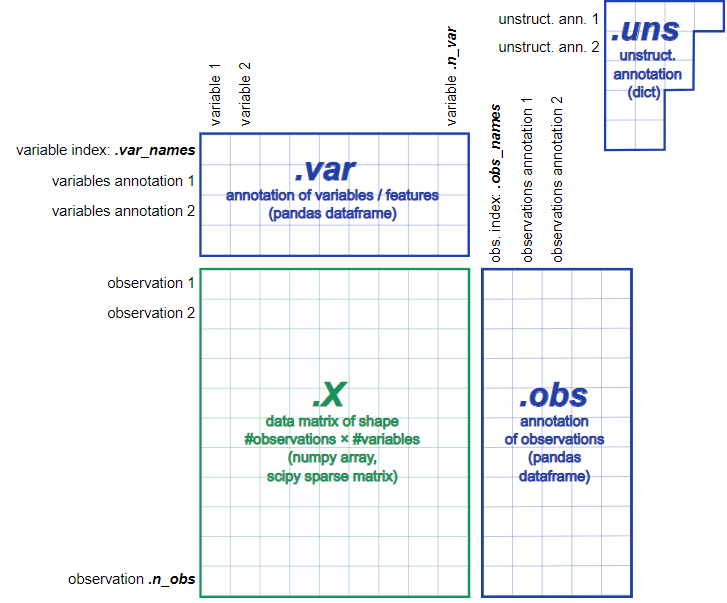

Here, the observations of the data points (metadata) are found in the **.obs** dataframe, the annotations of the features (genes) are found in the **.var** and the actual data itself (counts) is stored in the **.X** sparse matrix. I can see above, from the AnnData schema, the types of annotations that have been made for the genes and observations.

# 2. Create cellxgene median counts matrix

In [3]:
#creates a new dataframe from a scipy sparse matrix where each column is stored as a sparse array
tabula_counts = pd.DataFrame.sparse.from_spmatrix(tabula.X)

In [4]:
#exponentiate count values to counts per million (CPM)
tabula_counts = np.expm1(tabula_counts)

In [5]:
#convert sparse array columns to dense array
tabula_counts = tabula_counts.sparse.to_dense()

In [6]:
#add cell type and tissue type identifiers
cell_type = tabula.obs['cell_ontology_class'].values.to_list()
tissue = tabula.obs['tissue_in_publication'].values.to_list()

tabula_counts.insert(0, 'tissue_in_publication', tissue)
tabula_counts.insert(1, 'cell_type', cell_type)

/tmp/ipykernel_2840/2553052641.py:1: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  cell_type = tabula.obs['cell_ontology_class'].values.to_list()
/tmp/ipykernel_2840/2553052641.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  tissue = tabula.obs['tissue_in_publication'].values.to_list()


In [7]:
tabula_counts

,tissue_in_publication,cell_type,0,1,2,3,4,5,6,7,...,58594,58595,58596,58597,58598,58599,58600,58601,58602,58603
0,Liver,macrophage,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,90.290840,0.0,0.0,0.0,20.458338,4.670524,0.0,103.710594,0.0,0.00000
1,Liver,monocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,88.436073,0.0,0.0,0.0,19.309458,0.000000,0.0,132.029144,0.0,0.00000
2,Liver,endothelial cell of hepatic sinusoid,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,99.664101,0.0,0.0,0.0,45.157948,2.046921,0.0,108.283028,0.0,0.00000
3,Liver,macrophage,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,76.020004,0.0,0.0,0.0,18.596909,0.000000,0.0,95.801949,0.0,0.00000
4,Liver,liver dendritic cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,84.088768,0.0,0.0,0.0,22.193886,0.000000,0.0,92.070175,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483147,Vasculature,endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,30.683167,0.0,0.0,0.0,18.817291,1.139175,0.0,7.660368,0.0,0.00000
483148,Vasculature,endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,72.125992,0.0,0.0,0.0,34.163982,8.198351,0.0,31.683420,0.0,0.00000
483149,Vasculature,endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,19.729446,0.0,0.0,0.0,71.676071,11.805891,0.0,52.349396,0.0,210.66539
483150,Vasculature,endothelial cell,0.0,22025.464844,0.0,0.0,0.0,0.0,0.0,0.0,...,10.089444,0.0,0.0,0.0,122.275734,55.048557,0.0,50.723656,0.0,0.00000


In [8]:
#calculate median of each gene grouped by cell type and tissue
tabula_counts = tabula_counts.groupby(['tissue_in_publication', 'cell_type']).median()

In [9]:
tabula_counts

0      1      \
tissue_in_publication cell_type                                            
Bladder               b cell                                  0.0    0.0   
                      bladder urothelial cell                 0.0    0.0   
                      capillary endothelial cell              0.0    0.0   
                      endothelial cell of lymphatic vessel    0.0    0.0   
                      fibroblast                              0.0    0.0   
...                                                           ...    ...   
Vasculature           nk cell                                 0.0    0.0   
                      pericyte cell                           0.0    0.0   
                      plasma cell                             0.0    0.0   
                      smooth muscle cell                      0.0    0.0   
                      t cell                                  0.0    0.0   

                                                            2      3      \
tissue_in_publication cell_type                                            
Bladder               b cell                                  0.0    0.0   
                      bladder urothelial cell                 0.0    0.0   
                      capillary endothelial cell              0.0    0.0   
                      endothelial cell of lymphatic vessel    0.0    0.0   
                      fibroblast                              0.0    0.0   
...                                                           ...    ...   
Vasculature           nk cell                                 0.0    0.0   
                      pericyte cell                           0.0    0.0   
                      plasma cell                             0.0    0.0   
                      smooth muscle cell                      0.0    0.0   
                      t cell                                  0.0    0.0   

                                                            4      5      \
tissue_in_publication cell_type                                            
Bladder               b cell                                  0.0    0.0   
                      bladder urothelial cell                 0.0    0.0   
                      capillary endothelial cell              0.0    0.0   
                      endothelial cell of lymphatic vessel    0.0    0.0   
                      fibroblast                              0.0    0.0   
...                                                           ...    ...   
Vasculature           nk cell                                 0.0    0.0   
                      pericyte cell                           0.0    0.0   
                      plasma cell                             0.0    0.0   
                      smooth muscle cell                      0.0    0.0   
                      t cell                                  0.0    0.0   

                                                            6      7      \
tissue_in_publication cell_type                                            
Bladder               b cell                                  0.0    0.0   
                      bladder urothelial cell                 0.0    0.0   
                      capillary endothelial cell              0.0    0.0   
                      endothelial cell of lymphatic vessel    0.0    0.0   
                      fibroblast                              0.0    0.0   
...                                                           ...    ...   
Vasculature           nk cell                                 0.0    0.0   
                      pericyte cell                           0.0    0.0   
                      plasma cell                             0.0    0.0   
                      smooth muscle cell                      0.0    0.0   
                      t cell                                  0.0    0.0   

                                                            8      9      ...  \
tissue_in_publication c

In [12]:
#save groupedby matrix to a compressed pickle format
tabula_counts.to_pickle('median_exp_tabula_counts.pkl', compression = 'gzip')

In [15]:
#save matrix with reset index to a pickle format
tabula_counts.reset_index().to_pickle('median_exp_tabula_counts_long.pkl', compression = 'gzip')

# 3. Change gene index to ensemblid

In [43]:
#read in grouped by matrix from pickle format
tabula_counts = pd.read_pickle('median_exp_tabula_counts.pkl', compression = 'gzip')

In [44]:
#add ensemblid to column index to identify genes
ensemblid = tabula.var.index.values
tabula_counts = tabula_counts.set_axis(ensemblid, axis = 1)

In [45]:
tabula_counts

ENSG00000223972  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell                                            0.0   

                                                            ENSG00000227232  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell                                            0.0   

                                                            ENSG00000278267  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell                                            0.0   

                                                            ENSG00000243485  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell

In [7]:
#save ensemblid versions
tabula_counts.to_pickle('median_exp_tabula_counts_ensemblid.pkl', compression = 'gzip')
tabula_counts.reset_index().to_pickle('median_exp_tabula_counts_ensemblid_long.pkl', compression = 'gzip')

# 4. Drop genes with 0 median expression across all cell types and tissues

In [50]:
#filter out columns (genes) that have zero median expression across all tissues and cell types
tabula_counts = tabula_counts.drop(tabula_counts.columns[(tabula_counts == 0).all()], axis = 1)
tabula_counts

ENSG00000225972  \
tissue_in_publication cell_type                                               
Bladder               b cell                                       5.360208   
                      bladder urothelial cell                      0.195675   
                      capillary endothelial cell                   0.000000   
                      endothelial cell of lymphatic vessel         0.000000   
                      fibroblast                                   0.000000   
...                                                                     ...   
Vasculature           nk cell                                      1.710777   
                      pericyte cell                                0.000000   
                      plasma cell                                  0.000000   
                      smooth muscle cell                           0.000000   
                      t cell                                       0.000000   

                                                            ENSG00000225630  \
tissue_in_publication cell_type                                               
Bladder               b cell                                       0.000000   
                      bladder urothelial cell                      1.686289   
                      capillary endothelial cell                   0.000000   
                      endothelial cell of lymphatic vessel         0.000000   
                      fibroblast                                   0.000000   
...                                                                     ...   
Vasculature           nk cell                                      0.000000   
                      pericyte cell                                0.000000   
                      plasma cell                                  0.000000   
                      smooth muscle cell                           0.000000   
                      t cell                                       0.000000   

                                                            ENSG00000237973  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell                                            0.0   

                                                            ENSG00000229344  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell

Filtering out zero median expression genes across all cell types and tissues removes 44,379 genes that do not convey any information to our gene expression analysis across tissues.

In [52]:
#save non-zero median expression matrix
tabula_counts.to_pickle('non_zero_median_tabula_counts_ensemblid.pkl', compression = 'gzip')

# 5. Carry out pipeline above with UBERON IDs included

In [2]:
#read in Tabula Sapiens Atlas for all cells
tabula = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

tabula

AnnData object with n_obs × n_vars = 483152 × 58604
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_id_c

In [3]:
#creates a new dataframe from a scipy sparse matrix where each column is stored as a sparse array
tabula_counts = pd.DataFrame.sparse.from_spmatrix(tabula.X)

In [4]:
#exponentiate count values to counts per million (CPM)
tabula_counts = np.expm1(tabula_counts)

In [5]:
#convert sparse array columns to dense array
tabula_counts = tabula_counts.sparse.to_dense()

In [6]:
#add cell type and tissue type identifiers
cell_type = tabula.obs['cell_ontology_class'].values.to_list()
uberon_id = tabula.obs['tissue_ontology_term_id'].values.to_list()

tabula_counts.insert(0, 'uberon_id', uberon_id)
tabula_counts.insert(1, 'cell_type', cell_type)

/tmp/ipykernel_4941/3801806086.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  cell_type = tabula.obs['cell_ontology_class'].values.to_list()
/tmp/ipykernel_4941/3801806086.py:3: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  uberon_id = tabula.obs['tissue_ontology_term_id'].values.to_list()


In [7]:
tabula_counts

,uberon_id,cell_type,0,1,2,3,4,5,6,7,...,58594,58595,58596,58597,58598,58599,58600,58601,58602,58603
0,UBERON:0002107,macrophage,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,90.290840,0.0,0.0,0.0,20.458338,4.670524,0.0,103.710594,0.0,0.00000
1,UBERON:0002107,monocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,88.436073,0.0,0.0,0.0,19.309458,0.000000,0.0,132.029144,0.0,0.00000
2,UBERON:0002107,endothelial cell of hepatic sinusoid,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,99.664101,0.0,0.0,0.0,45.157948,2.046921,0.0,108.283028,0.0,0.00000
3,UBERON:0002107,macrophage,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,76.020004,0.0,0.0,0.0,18.596909,0.000000,0.0,95.801949,0.0,0.00000
4,UBERON:0002107,liver dendritic cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,84.088768,0.0,0.0,0.0,22.193886,0.000000,0.0,92.070175,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483147,UBERON:0000947,endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,30.683167,0.0,0.0,0.0,18.817291,1.139175,0.0,7.660368,0.0,0.00000
483148,UBERON:0000947,endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,72.125992,0.0,0.0,0.0,34.163982,8.198351,0.0,31.683420,0.0,0.00000
483149,UBERON:0000947,endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,19.729446,0.0,0.0,0.0,71.676071,11.805891,0.0,52.349396,0.0,210.66539
483150,UBERON:0000947,endothelial cell,0.0,22025.464844,0.0,0.0,0.0,0.0,0.0,0.0,...,10.089444,0.0,0.0,0.0,122.275734,55.048557,0.0,50.723656,0.0,0.00000


In [8]:
tabula_counts.uberon_id.nunique() #these uberon_id match the 'tissue' column in obs

45

In [9]:
#calculate median of each gene grouped by cell type and tissue
tabula_counts = tabula_counts.groupby(['uberon_id', 'cell_type']).median()

In [10]:
#save groupedby matrix to a compressed pickle format
tabula_counts.to_pickle('median_exp_tabula_counts_uberon_id.pkl', compression = 'gzip')

In [11]:
#save matrix with reset index to a pickle format
tabula_counts.reset_index().to_pickle('median_exp_tabula_counts_uberon_id_long.pkl', compression = 'gzip')

In [12]:
tabula_counts

0      1      2      3      4      \
uberon_id      cell_type                                                        
UBERON:0000016 b cell                         0.0    0.0    0.0    0.0    0.0   
               endothelial cell               0.0    0.0    0.0    0.0    0.0   
               mast cell                      0.0    0.0    0.0    0.0    0.0   
               myeloid cell                   0.0    0.0    0.0    0.0    0.0   
               pancreatic acinar cell         0.0    0.0    0.0    0.0    0.0   
...                                           ...    ...    ...    ...    ...   
UBERON:0018707 plasma cell                    0.0    0.0    0.0    0.0    0.0   
               plasmacytoid dendritic cell    0.0    0.0    0.0    0.0    0.0   
               smooth muscle cell             0.0    0.0    0.0    0.0    0.0   
               t cell                         0.0    0.0    0.0    0.0    0.0   
               vein endothelial cell          0.0    0.0    0.0    0.0    0.0   

                                            5      6      7      8      9      \
uberon_id      cell_type                                                        
UBERON:0000016 b cell                         0.0    0.0    0.0    0.0    0.0   
               endothelial cell               0.0    0.0    0.0    0.0    0.0   
               mast cell                      0.0    0.0    0.0    0.0    0.0   
               myeloid cell                   0.0    0.0    0.0    0.0    0.0   
               pancreatic acinar cell         0.0    0.0    0.0    0.0    0.0   
...                                           ...    ...    ...    ...    ...   
UBERON:0018707 plasma cell                    0.0    0.0    0.0    0.0    0.0   
               plasmacytoid dendritic cell    0.0    0.0    0.0    0.0    0.0   
               smooth muscle cell             0.0    0.0    0.0    0.0    0.0   
               t cell                         0.0    0.0    0.0    0.0    0.0   
               vein endothelial cell          0.0    0.0    0.0    0.0    0.0   

                                            ...      58594  58595  58596  \
uberon_id      cell_type                    ...                            
UBERON:0000016 b cell                       ...  16.788368    0.0    0.0   
               endothelial cell             ...  20.662191    0.0    0.0   
               mast cell                    ...  26.537643    0.0    0.0   
               myeloid cell                 ...  11.879559    0.0    0.0   
               pancreatic acinar cell       ...   9.739045    0.0    0.0   
...                                         ...        ...    ...    ...   
UBERON:0018707 plasma cell                  ...  10.373882    0.0    0.0   
               plasmacytoid dendritic cell  ...  32.792406    0.0    0.0   
               smooth muscle cell           ...  58.824202    0.0    0.0   
               t cell                       ...  28.698874    0.0    0.0   
               vein endothelial cell        ...  28.704862    0.0    0.0   

                                            58597      58598     58599  58600  \
uberon_id      cell_type                                                        
UBERON:0000016 b cell                         0.0   3.646845  0.022886    0.0   
               endothelial cell               0.0   8.247749  0.000000    0.0   
               mast cell                      0.0  13.406758  2.008776    0.0   
               myeloid cell                   0.0   1.251252  0.235262    0.0   
               pancreatic acinar cell         0.0   1.735478  0.165051    0.0   
...                                           ...        ...       ...    ...   
UBERON:0018707 plasma cell                    0.0   3.658163  0.428860    0.0   
               plasmacytoid dendritic cell    0.0  10.742856  0.000000    0.0   
               smooth muscle cell             0.0  19.368109  1.516458    0.0   
               t cell                         0.0  10.42

In [13]:
#add ensemblid to column index to identify genes
ensemblid = tabula.var.index.values
tabula_counts = tabula_counts.set_axis(ensemblid, axis = 1)

In [17]:
tabula_counts

ENSG00000223972  ENSG00000227232  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000278267  ENSG00000243485  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000284332  ENSG00000237613  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000268020  ENSG00000240361  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                    

In [20]:
#filter out columns (genes) that have zero median expression across all tissues and cell types
tabula_counts = tabula_counts.drop(tabula_counts.columns[(tabula_counts == 0).all()], axis = 1)
tabula_counts

ENSG00000227232  ENSG00000268903  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000241860  ENSG00000279457  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000228463  ENSG00000237094  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000225972  ENSG00000225630  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                              0.000000         0.101790   
               endothelial cell                    0.000000         0.000000   
               mast cell                           0.027070         1.606588   
               myeloid cell                        0.000000         0.000000   
               pancreatic acinar cell              0.000000         0.000000   
...                                                     ...              ...   
UBERON:0018707 plasma cell                         0.000000         0.000000   
               plasmacytoid dendritic cell         0.000000         0.000000   
               smooth muscle cell                  2.210239         0.000000   
               t cell                    

In [22]:
#save groupedby matrix to a compressed pickle format
tabula_counts.to_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')

In [23]:
#save matrix with reset index to a pickle format
tabula_counts.reset_index().to_pickle('median_exp_tabula_counts_uberon_ensemblid_long.pkl', compression = 'gzip')

# 6. Pipeline with 'tissue'

In [3]:
#read in Tabula Sapiens Atlas for all cells
tabula = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

tabula

AnnData object with n_obs × n_vars = 483152 × 58604
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_id_c

In [7]:
#creates a new dataframe from a scipy sparse matrix where each column is stored as a sparse array
tabula_counts = pd.DataFrame.sparse.from_spmatrix(tabula.X)

In [8]:
#exponentiate count values to counts per million (CPM)
tabula_counts = np.expm1(tabula_counts)

In [9]:
#convert sparse array columns to dense array
tabula_counts = tabula_counts.sparse.to_dense()

In [10]:
#add cell type and tissue type identifiers
cell_type = tabula.obs['cell_ontology_class'].values.to_list()
tissue_id = tabula.obs['tissue'].values.to_list()

tabula_counts.insert(0, 'tissue_id', tissue_id)
tabula_counts.insert(1, 'cell_type', cell_type)

/tmp/ipykernel_2838/69801686.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  cell_type = tabula.obs['cell_ontology_class'].values.to_list()
/tmp/ipykernel_2838/69801686.py:3: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  tissue_id = tabula.obs['tissue'].values.to_list()


In [11]:
tabula_counts

,tissue_id,cell_type,0,1,2,3,4,5,6,7,...,58594,58595,58596,58597,58598,58599,58600,58601,58602,58603
0,liver,macrophage,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,90.290840,0.0,0.0,0.0,20.458338,4.670524,0.0,103.710594,0.0,0.00000
1,liver,monocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,88.436073,0.0,0.0,0.0,19.309458,0.000000,0.0,132.029144,0.0,0.00000
2,liver,endothelial cell of hepatic sinusoid,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,99.664101,0.0,0.0,0.0,45.157948,2.046921,0.0,108.283028,0.0,0.00000
3,liver,macrophage,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,76.020004,0.0,0.0,0.0,18.596909,0.000000,0.0,95.801949,0.0,0.00000
4,liver,liver dendritic cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,84.088768,0.0,0.0,0.0,22.193886,0.000000,0.0,92.070175,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483147,aorta,endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,30.683167,0.0,0.0,0.0,18.817291,1.139175,0.0,7.660368,0.0,0.00000
483148,aorta,endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,72.125992,0.0,0.0,0.0,34.163982,8.198351,0.0,31.683420,0.0,0.00000
483149,aorta,endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,19.729446,0.0,0.0,0.0,71.676071,11.805891,0.0,52.349396,0.0,210.66539
483150,aorta,endothelial cell,0.0,22025.464844,0.0,0.0,0.0,0.0,0.0,0.0,...,10.089444,0.0,0.0,0.0,122.275734,55.048557,0.0,50.723656,0.0,0.00000


In [12]:
#calculate median of each gene grouped by cell type and tissue
tabula_counts = tabula_counts.groupby(['tissue_id', 'cell_type']).median()

In [13]:
#add ensemblid to column index to identify genes
ensemblid = tabula.var.index.values
tabula_counts = tabula_counts.set_axis(ensemblid, axis = 1)

In [14]:
#filter out columns (genes) that have zero median expression across all tissues and cell types
tabula_counts = tabula_counts.drop(tabula_counts.columns[(tabula_counts == 0).all()], axis = 1)
tabula_counts

ENSG00000227232  ENSG00000268903  \
tissue_id      cell_type                                              
adipose tissue b cell                          0.0              0.0   
               endothelial cell                0.0              0.0   
               fibroblast                      0.0              0.0   
               leucocyte                       0.0              0.0   
               macrophage                      0.0              0.0   
...                                            ...              ...   
vasculature    nk cell                         0.0              0.0   
               pericyte cell                   0.0              0.0   
               plasma cell                     0.0              0.0   
               smooth muscle cell              0.0              0.0   
               t cell                          0.0              0.0   

                                   ENSG00000241860  ENSG00000279457  \
tissue_id      cell_type                                              
adipose tissue b cell                          0.0              0.0   
               endothelial cell                0.0              0.0   
               fibroblast                      0.0              0.0   
               leucocyte                       0.0              0.0   
               macrophage                      0.0              0.0   
...                                            ...              ...   
vasculature    nk cell                         0.0              0.0   
               pericyte cell                   0.0              0.0   
               plasma cell                     0.0              0.0   
               smooth muscle cell              0.0              0.0   
               t cell                          0.0              0.0   

                                   ENSG00000228463  ENSG00000237094  \
tissue_id      cell_type                                              
adipose tissue b cell                          0.0              0.0   
               endothelial cell                0.0              0.0   
               fibroblast                      0.0              0.0   
               leucocyte                       0.0              0.0   
               macrophage                      0.0              0.0   
...                                            ...              ...   
vasculature    nk cell                         0.0              0.0   
               pericyte cell                   0.0              0.0   
               plasma cell                     0.0              0.0   
               smooth muscle cell              0.0              0.0   
               t cell                          0.0              0.0   

                                   ENSG00000225972  ENSG00000225630  \
tissue_id      cell_type                                              
adipose tissue b cell                          0.0          0.00000   
               endothelial cell                0.0          0.00000   
               fibroblast                      0.0          0.00000   
               leucocyte                       0.0          0.00000   
               macrophage                      0.0          0.00000   
...                                            ...              ...   
vasculature    nk cell                         0.0          0.00000   
               pericyte cell                   0.0          0.00000   
               plasma cell                     0.0          0.40251   
               smooth muscle cell              0.0          0.00000   
               t cell                          0.0          0.00000   

                                   ENSG00000237973  ENSG00000229344  ...  \
tissue_id      cell_type                                             ...   
adipose tissue b cell                          0.0         0.000000  ...   
               endothelial cell                0.0         0.000000  ...   
               fibroblast          

In [15]:
#save groupedby matrix to a compressed pickle format
tabula_counts.to_pickle('median_exp_tabula_counts_tissue_ensembl_id.pkl', compression = 'gzip')